## Project: Product Search in Supermarket Shelves -- Computer Vision 
__Name__: Ahmet Turkmen

__Number__: 110510016

__Level__: Bachelor CE Student

__Note: The all data and notebook can be found on my Github account here : https://github.com/ahmetturkmen/CV-P1-2019-2020__

In [ ]:
! pip install opencv-contrib-python
! pip install opencv-python
! pip install numpy
! pip install matplotlib

In [1]:
%autosave 100
import matplotlib.cm as cm
import numpy as np 
import cv2
import matplotlib.pyplot as plt 
import os


Autosaving every 100 seconds


### Algorithm

First of all, I have tried different algorithms on different datasets however the most preferred and valuable one is SIFT local feature descriptor. I got benefit of example which we did in our class time. Firstly, I have applied to some filters to images to get rid of twinkling on products' pochette however I noticed that it is not super necessary thing to do because the important part of matching two images comes from different interest points, of course it might effect in some cases but in this case, NO. 

My approach to this problems goes as follows: 

- __Read images__
    - In grayscale and RGB format ( RGB format is used to show end result)
- __Resize images__ 
    - In some cases, product image might be too small on internet for this reason it is good to have such an function.
- __SIFT implementation__
    - Finding key points on both images to happen matches

- __FLANN Based mathcer used__
    - It is "Fast Library for Approximate Nearest Neighbors", fast and reliable technique, so it finds mathces based on approximate nearest neighbors. Additionaly, FLANN is much more faster than BFMatcher . 
        
- __Thresholding mathces (per Lowe's ratio test)__

    - Eliminating poorly mathced ones to get show better results. 
    
- __Homography and Perspective transformation__

    - This is used to encircle product on shelf image by creating mask, this technique is quite usefull. 

- __Drawing mathces on image__
    - Using ``` cv2.drawMatches ``` function draw lines between matching points on both image. 
    
- __Encircle product on shelf image__

    - Encircling product on shelf image. 
    - Code snippet: 
    
        ```
         cv2.line(matched_image, (int(dst[0,0,0] + img1.shape[1]), int(dst[0,0,1])),\
        (int(dst[1,0,0] + img1.shape[1]), int(dst[1,0,1])), (0,0,255), encircle_width)
        cv2.line(matched_image, (int(dst[1,0,0] + img1.shape[1]), int(dst[1,0,1])),\
        (int(dst[2,0,0] + img1.shape[1]), int(dst[2,0,1])), (0,0,255), encircle_width)
        cv2.line(matched_image, (int(dst[2,0,0] + img1.shape[1]), int(dst[2,0,1])),\
        (int(dst[3,0,0] + img1.shape[1]), int(dst[3,0,1])), (0,0,255), encircle_width)
        cv2.line(matched_image, (int(dst[3,0,0] + img1.shape[1]), int(dst[3,0,1])),\
         (int(dst[0,0,0] + img1.shape[1]), int(dst[0,0,1])), (0,0,255), encircle_width)
        ```
    
__Additional information is given inside  run algorithm function below__


    
    
    
    

In [5]:
## Helper Functions


def load_images(directory):
    return [cv2.imread(file_) for file_ in glob.glob('data/*.jpg)')]


def resize_image(img,scale_percent):
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    return (width,height)

## Main algorithm; which find matching points and encircle search product on shelves. 


def run_algorithm(product_image_path ,shelf_image_path,scale_shelf=False,scale_percent=0,encircle_width = 35):
    print("FIRST ARGUMENT : IMAGE OF THE PRODUCT \
           SECOND ARGUMENT : IMAGE OF THE SHELF TO BE SEARCHED ON ... ")
    
    img1 = cv2.imread("data_/products/"+product_image_path,0)
    img2  = cv2.imread("data_/shelves/"+shelf_image_path,0) 
    
    ## RGB version of the images are used to show last result on colored one as requested. 
    
    
    img1_rgb = cv2.imread("data_/products/"+product_image_path,1)
    img2_rgb = cv2.imread("data_/shelves/"+shelf_image_path,1) 
    THRESHOLD_MATCH_COUNT = 10
    dim_img1 = resize_image(img1,500)
    dim_img2 = resize_image(img2,scale_percent)
    
    if scale_shelf==True: 
        img2 = cv2.resize(img2,dim_img2,interpolation=cv2.INTER_AREA)
        img2_rgb=cv2.resize(img2_rgb,dim_img2,interpolation=cv2.INTER_AREA)
    
    img1 = cv2.resize(img1, dim_img1, interpolation = cv2.INTER_AREA)
    img1_rgb=cv2.resize(img1_rgb, dim_img1, interpolation = cv2.INTER_AREA)

    #    Initiate SIFT detector, in upgraded versions of OpenCV this function is patented and not free 
    sift = cv2.SIFT_create()
    

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1,des2,k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)

    ## Eliminating not good matches by defining threshold 
    if len(good)>THRESHOLD_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()

        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
    #     polyline_params = dict(isClosed=True,
    #                        color=(255,0,0),
    #                        thickness=10,
    #                        lineType=cv2.LINE_AA,
    #                        shift=0)
    #     img2 = cv2.polylines(img2,[np.int32(dst)],True,(0, 255 ,0),4, cv2.LINE_AA)


    else:
        print ("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
        matchesMask = None
   
    ## Defining parameters of draw funciton for insterest points of both image
    
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)
    plt.figure(num=None, figsize=(10, 7), dpi=80, facecolor='w', edgecolor='k')
    matched_image = cv2.drawMatches(img1_rgb,kp1,img2_rgb,kp2,good,None,**draw_params)

    ## Here, we are encircling the search image on target one. 
    
    cv2.line(matched_image, (int(dst[0,0,0] + img1.shape[1]), int(dst[0,0,1])),\
        (int(dst[1,0,0] + img1.shape[1]), int(dst[1,0,1])), (0,0,255), encircle_width)
    cv2.line(matched_image, (int(dst[1,0,0] + img1.shape[1]), int(dst[1,0,1])),\
        (int(dst[2,0,0] + img1.shape[1]), int(dst[2,0,1])), (0,0,255), encircle_width)
    cv2.line(matched_image, (int(dst[2,0,0] + img1.shape[1]), int(dst[2,0,1])),\
        (int(dst[3,0,0] + img1.shape[1]), int(dst[3,0,1])), (0,0,255), encircle_width)
    cv2.line(matched_image, (int(dst[3,0,0] + img1.shape[1]), int(dst[3,0,1])),\
            (int(dst[0,0,0] + img1.shape[1]), int(dst[0,0,1])), (0,0,255), encircle_width)

    plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB)),plt.show()
    

### Dataset 
In this dataset, I have 5 shelves and 2 products for each shelf to be searched, I have created two different directories which are _shelves_ and  _products_ under _data_\_ directory. So,  in total I have, 10 Products 5 Shelves.


In [3]:
import os
print(os.listdir('E:/1/Product-Search-in-Supermarket-Shelves/data_/products'))
print(os.listdir('E:/1/Product-Search-in-Supermarket-Shelves/data_/shelves'))

['b1_product.jpg', 'c1_product.jpg', 'c2_product.jpg', 'f1_product.jpg', 'f2_product.jpg', 'r1_product.jpg', 'r2_product.jpg', 'st1_product.jpg', 'st2_product.jpg', 't1_product.jpg', 't2_product.jpg']
['b1_shelf.jpg', 'c1_shelf.jpg', 'd1_shelf.jpg', 'f1_shelf.jpg', 'm1_shelf.jpg', 'p1_shelf.jpg', 'r1_shelf.jpg', 's1_shelf.jpg', 'smp1_shelf.jpg', 'st1_shelf.jpg', 't1_shelf.jpg']


### Category -1 

### Search on Category (Shelf) -1 for Product-1 ...

_*Note that cv2.cvtColor swaps colors (BGR) -> (RGB) , for that reason I have added (0,0,255 ) which is normally BLUE however when that function implemented, it is turned to RED > (255,0,0)*_

FIRST ARGUMENT : IMAGE OF THE PRODUCT            SECOND ARGUMENT : IMAGE OF THE SHELF TO BE SEARCHED ON ... 


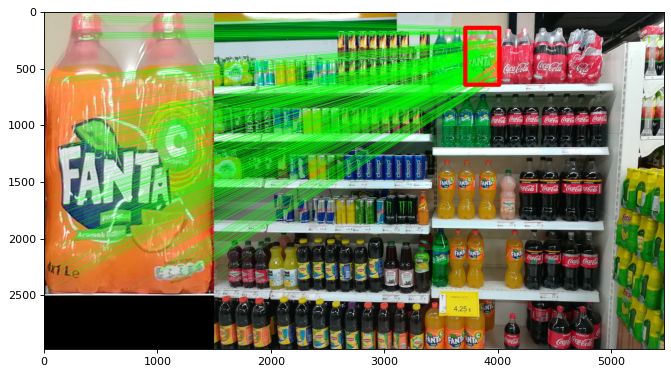

In [6]:
run_algorithm('c1_product.jpg','c1_shelf.jpg')

### Search on Category (Shelf) -1 for Product-2 ...


FIRST ARGUMENT : IMAGE OF THE PRODUCT            SECOND ARGUMENT : IMAGE OF THE SHELF TO BE SEARCHED ON ... 


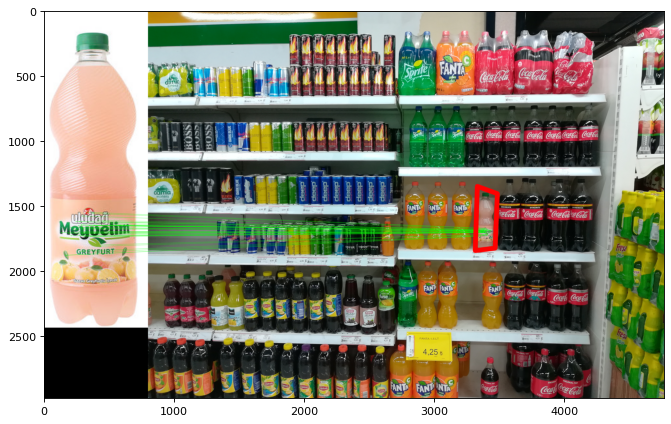

In [7]:
run_algorithm('c2_product.jpg','c1_shelf.jpg')

## Category (Shelf) - 2

### Search on Category (Shelf) -2 for Product -1 ....

FIRST ARGUMENT : IMAGE OF THE PRODUCT            SECOND ARGUMENT : IMAGE OF THE SHELF TO BE SEARCHED ON ... 


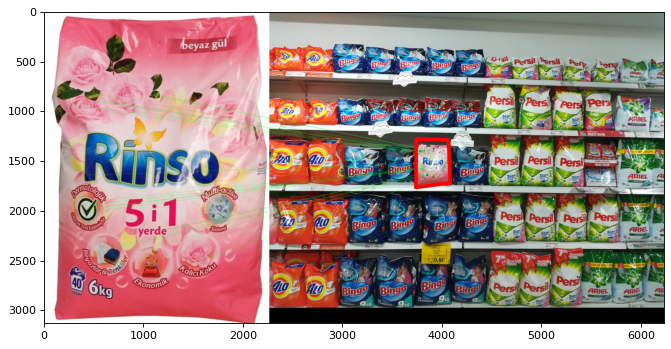

In [8]:
run_algorithm('r1_product.jpg','r1_shelf.jpg')

### Search on Category (Shelf) -2 for Product-2 ...

FIRST ARGUMENT : IMAGE OF THE PRODUCT            SECOND ARGUMENT : IMAGE OF THE SHELF TO BE SEARCHED ON ... 


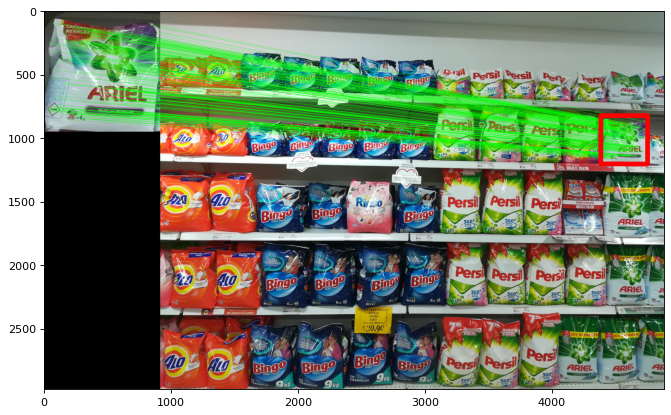

In [9]:
run_algorithm('r2_product.jpg','r1_shelf.jpg')

## Category (Shelf) -3 

### Search on Category (Shelf) -3 for Product-1 ...

In [10]:
run_algorithm('f1_product.jpg','f1_shelf.jpg',scale_shelf=True, scale_percent=200,encircle_width=50)

FIRST ARGUMENT : IMAGE OF THE PRODUCT            SECOND ARGUMENT : IMAGE OF THE SHELF TO BE SEARCHED ON ... 


### Search on Category (Shelf) -3 for Product-2 ...

In [ ]:
run_algorithm('f2_product.jpg','f1_shelf.jpg',scale_shelf=True,scale_percent=200,encircle_width=50)

## Category (Shelf) -4

### Search on Category (Shelf) -4 for Product-1 ...

In [ ]:
run_algorithm('st1_product.jpg','st1_shelf.jpg')

### Search on Category (Shelf) -4 for Product-2 ...

In [ ]:
run_algorithm('st2_product.jpg','st1_shelf.jpg')

## Category (Shelf) -5 

### Search on Category (Shelf) -5 for Product-1


In [ ]:
run_algorithm('t1_product.jpg','t1_shelf.jpg')

### Search on Category (Shelf) -5 for Product-2

In [ ]:

run_algorithm('t2_product.jpg','t1_shelf.jpg',scale_shelf=True, scale_percent=300,encircle_width=80)


# Experimental Results

### a) How many products are correctly found (#correct detections)?

I have collected shelf images from 5 different shelves and when I applied, SIFT, HOMOGRAPY and perspective transform to target and search image. I have correctly found all of them,  since there should be 2 search product for each category, I correctly found 10 products. (all of them.)The results of the algorithm is already shown above. There is no doubt that while working such a project I had to re-watch Udacity course on sift, homography and perspective transform. 

### b) How many miss-detections did you get?


There is no miss detection in my dataset, I did NOT accidently found another product than searched one. It can also be observed from results of the algorithm above. 


### c) How many false detections did you get?
 
 None. 
 
### d) Give numbers and ratios for each search item. Discuss your results. Explain why did you get those results for the best/the worst search.

- __Category 1__ 
   
    - Product 1 > matched perfectly (%100)
    - Product 2 > matched perfectly (%100)

- __Category 2__ 
    
    - Product 1 > matched perfectly (%100)
    - Product 2 > matched perfectly (%100)

- __Category 3__ 
    
    - Product 1 > matched perfectly (%100) (Although there are less interest points compared to others,     algorithm is performed very well.)

    - Product 2 > matched perfectly (%100) 
- __Category 4__ 
    
    - Product 1 > matched perfectly (%100) 
    - Product 2 > matched perfectly (%100) 
 
- __Category 5__

    - Product 1 > matched perfectly (%100) 
    - Product 2 > matched perfectly (%100) (Although the product is not clear in shelf image, the algorithm is performed 
         very well. )


The main reason of getting best search results is understanding how an image can differentiate between each other, as well as, understanding of SIFT, Homograpy and perspective tranform operations. Besides, I tried to give importance on taking pictures at enough distance (not too away or not too close) and not including shadows ( which might require extra filtring techniques to implement.)

# Challanges

 The main challenge was building required enviroment, I have tried different techniques and algorithms on feature matching. However when I started to try SIFT algorithm using OpenCV, the problems started seriosly, since SIFT algorithm is available in lower versions of OpenCV and another branch of OpenCV, I had to solve this problem on my local computer. Yet, I could not deal with it on my local computer because it requires reliable and fast internet connection, for this reason at the end of my hopes, I decided to use Cloud Computing, I have rent 30 GB Memory, 8 Core and 100 GB SSD server from Google. Then, I configured machine according to my desire to solve this problem, I install following OpenCV libraries to get access SIFT algorithm : 
  
```
pip install opencv-contrib-python==3.4.2.17

pip install opencv-python==3.4.2.17
 
```

When those packages are installed correctly, my problem is solved on getting access to SIFT algorithm. 

Another challange was learning homograpgy and perspective transform in order to draw encircle around the product on shelf images. So, I have spent a lot of time on watching Udacity course and searching way to complete this challenge. Finally, I understood how it works and why it is required, then I wrote the implementations. 